In [1]:
from graphviz import Digraph

def trace(root):
    #Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR == Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
        if n._op:
            #If this value is a result of some operation, then create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #Connect n1 to the node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [2]:
import math

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #Its an empty function by default. This is what will do that gradient calculation at each of the operations.
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
          self.grad = 1.0 * out.grad
          other.grad = 1.0 * out.grad

        out._backward = backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
          self.grad = other.data * out.grad
          other.grad = self.data * out.grad

        out._backward = backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
          self.grad = 1 - (t**2) * out.grad

        out._backward = backward
        return out

    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

In [13]:
#Inputs x1, x2 of the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#Weights w1, w2 of the neuron - The synaptic values
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#The bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

#The summation
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

#n is basically the cell body, but without the activation function
n = x1w1x2w2 + b; n.label = 'n'

#Now we pass n to the activation function
o = n.tanh(); o.label = 'o'

In [5]:
o.grad = 1.0 #This is the base case, we set this

In [8]:
o.backward()

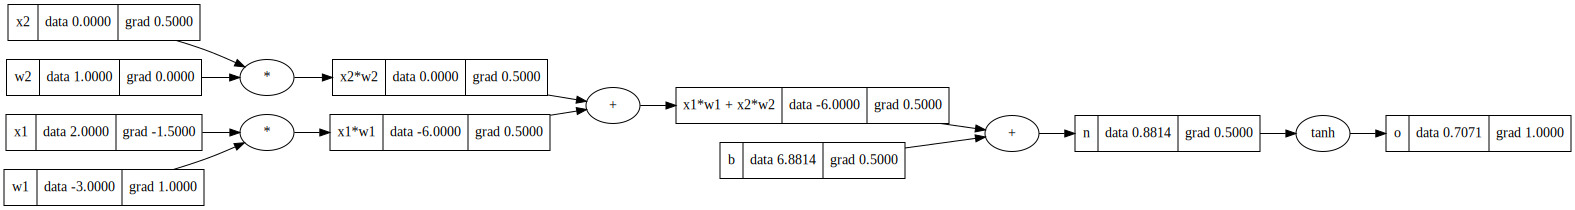

In [9]:
draw_dot(o)

-----------------

Now, here we have noticed a bug. Which we can see in these following examples

Example 1

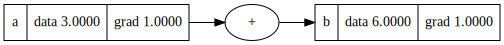

In [10]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

So here, the data value is correct, but the grad value is wrong. \
\
The derivative of b wrt a, in this equation b = a + a, is 2. Because it's 1+1, therefore 2 \
\
In the graph the second arrow is right on top of the first one, so we only see one arrow. \
\
So it seems like one value is stored and when another same one comes, the first one gets over-written, and therefore only one of those values is considered.

Example 2

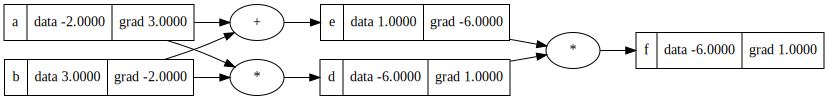

In [11]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

Okay so here, the derivative of f wrt a, b have two more cases: through e and d. \
\
So now through e: \
a and b grads are -6 respectively \
\
And through d: \
a is 3 and b is -2 \
\
So if you notice, through e was calculated first and then overwirtten by the calculations through d.

----------------

So, the solution is simple. We just need to ensure that the gradient values get accumelated if the same variable is used again. \
\
(Mathematical explaination or proof will be to use the **Multivariable case rule** of the chain rule.)
\
So basically we'll add the new value with the prev added one

So, let's update the Value object

In [12]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #Its an empty function by default. This is what will do that gradient calculation at each of the operations.
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
          self.grad += 1.0 * out.grad   #Adding it on
          other.grad += 1.0 * out.grad  #Adding it on

        out._backward = backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
          self.grad += other.data * out.grad  #Adding it on
          other.grad += self.data * out.grad  #Adding it on

        out._backward = backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
          self.grad += 1 - (t**2) * out.grad    #Adding it on

        out._backward = backward
        return out

    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

------------

Now lets check those examples again

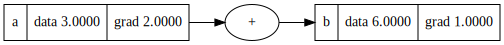

In [14]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

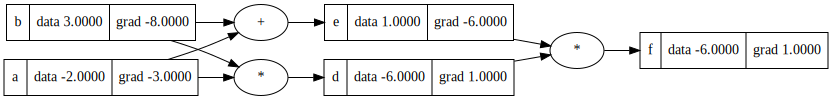

In [15]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

And now we've got the correct gradient values! \
\
So after the values have been deposited the first time, if it is called again, then it deposites it again on top it next. \
\
Example 1: \
1 + 1 = **2** \
\
Example 2: \
a -> -6 + 3 = **-3** \
b -> -6 + (- 2) = **-8**

Hence, resolving the issue :)